# Data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# setting number of training days 
# we can set how many days can the NN "see"
# i set it from 01.08.2020.
# so the first value was measured on 01.08.2020., and the last on 26.10.2020.

trd = 87

In [3]:
# data from http://idojarasbudapest.hu/archivalt-idojaras
# I converted HTML code of the tables and created a database via http://www.convertcsv.com/newsite/html-table-to-csv.htm
# I deleleted date,wind speed and precipitation amount
data = pd.read_excel('temperature_data.xlsx')

#computing the avg. temperature
data['avg'] = (data['max']+data["min"])/2
data = data.drop('min',1)
data = data.drop('max',1)
data = data.iloc[len(data)-trd:]
data = data.reset_index(drop=True)
data

# 0th index is 1st of august
# 86th index is 26th of october

,avg
0,25.00
1,25.15
2,26.60
3,25.10
4,22.80
...,...
82,13.00
83,13.60
84,15.00
85,13.10


In [4]:
# creating the np array X
lp 	= np.linspace(0,trd-1,trd)
X_raw = data['avg'][lp].to_numpy()

In [5]:
X_raw

array([25.  , 25.15, 26.6 , 25.1 , 22.8 , 25.1 , 27.1 , 28.55, 28.9 ,
       29.15, 28.3 , 28.1 , 26.95, 27.8 , 25.95, 23.25, 26.35, 24.75,
       24.5 , 25.05, 26.95, 28.05, 25.15, 25.45, 23.85, 25.35, 22.8 ,
       24.05, 27.4 , 28.85, 22.65, 17.7 , 18.95, 21.1 , 21.3 , 24.3 ,
       25.55, 23.45, 21.7 , 23.25, 23.65, 23.55, 25.05, 26.25, 26.45,
       26.75, 26.75, 25.2 , 20.35, 19.8 , 21.  , 22.3 , 23.3 , 22.9 ,
       21.9 , 20.05, 15.05, 13.2 , 16.45, 15.2 , 13.95, 14.85, 17.05,
       21.55, 20.  , 19.5 , 18.35, 15.2 , 14.7 , 15.45, 17.85, 13.6 ,
       11.55,  9.05, 10.3 , 11.45, 11.05,  9.6 , 10.1 , 11.05, 12.2 ,
       12.75, 13.  , 13.6 , 15.  , 13.1 , 15.35])

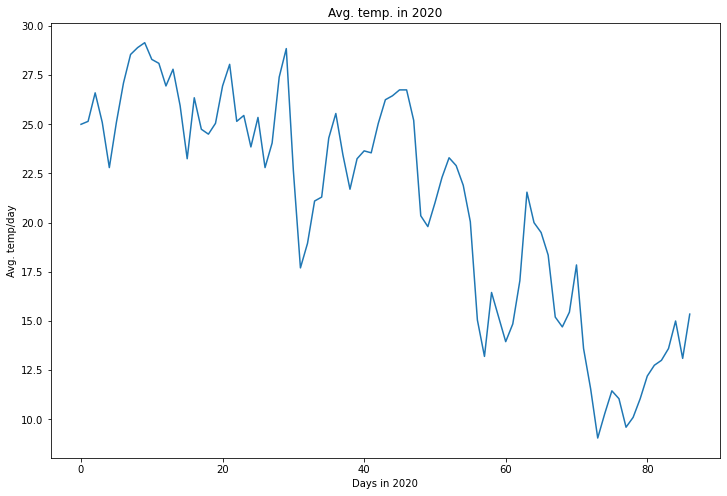

In [6]:
plt.figure(figsize=(12,8))
plt.title('Avg. temp. in 2020')
plt.xlabel('Days in 2020')
plt.ylabel('Avg. temp/day')
plt.plot(X_raw)

In [7]:
X_raw.shape

(87,)

# Model

code from https://github.com/BME-SmartLab-Education/vitmav45/blob/master/07/1D-CNN-regression.ipynb

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam

In [39]:
window_size = 20

In [40]:
#creating the timeseries data

def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0] , "Out of range 0 < {} < {} ".format(window_size,timeseries.shape[0])
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    Y = timeseries[window_size:]
    return X, Y

X,Y = make_timeseries_instances(X_raw, 20)
print(X.shape)
print(Y.shape)

(67, 20, 1)
(67,)


In [41]:
valid_split = 0.15
test_split = 0.15
nb_samples = X.shape[0]
nb_samples

67

In [42]:
valid_size = int(nb_samples*(1-test_split-valid_split))
test_size = int(nb_samples*(1-test_split))
X_train, Y_train = X[:valid_size], Y[:valid_size]
X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
X_test, Y_test   = X[test_size:], Y[test_size:]

In [43]:
model = Sequential()
model.add(Conv1D(64,4,activation='relu',input_shape=(window_size,1)))
model.add(MaxPooling1D())
#model.add(Conv1D(32,4,activation='relu'))
#model.add(MaxPooling1D())
#model.add(GlobalMaxPooling1D())
model.add(Flatten())
#model.add(Dense(12, activation='relu'))
model.add(Dense(1,activation='linear'))

In [44]:
model.compile(loss='mse',optimizer=Adam(),metrics=['mae'])

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 17, 64)            320       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit(X_train,Y_train,epochs=150, validation_data=(X_valid,Y_valid), verbose = 2)

Train on 46 samples, validate on 10 samples
Epoch 1/150
46/46 - 0s - loss: 602.2569 - mean_absolute_error: 24.1904 - val_loss: 183.0841 - val_mean_absolute_error: 13.1477
Epoch 2/150
46/46 - 0s - loss: 442.8176 - mean_absolute_error: 20.6664 - val_loss: 119.8509 - val_mean_absolute_error: 10.5077
Epoch 3/150
46/46 - 0s - loss: 310.1337 - mean_absolute_error: 17.1692 - val_loss: 71.2928 - val_mean_absolute_error: 7.9121
Epoch 4/150
46/46 - 0s - loss: 201.2890 - mean_absolute_error: 13.7389 - val_loss: 37.0332 - val_mean_absolute_error: 5.3867
Epoch 5/150
46/46 - 0s - loss: 121.3157 - mean_absolute_error: 10.3725 - val_loss: 16.0666 - val_mean_absolute_error: 3.2199
Epoch 6/150
46/46 - 0s - loss: 64.3229 - mean_absolute_error: 7.2272 - val_loss: 7.2858 - val_mean_absolute_error: 2.2115
Epoch 7/150
46/46 - 0s - loss: 30.7769 - mean_absolute_error: 4.9766 - val_loss: 8.7614 - val_mean_absolute_error: 2.5186
Epoch 8/150
46/46 - 0s - loss: 13.6295 - mean_absolute_error: 3.0798 - val_loss: 17

In [47]:
model.evaluate(X_test, Y_test)

11/11 [==============================] - 0s 181us/sample - loss: 8.9572 - mean_absolute_error: 2.5720


[8.957208633422852, 2.571955]

In [48]:
preds = model.predict(X_test)
targets = Y_test.tolist()

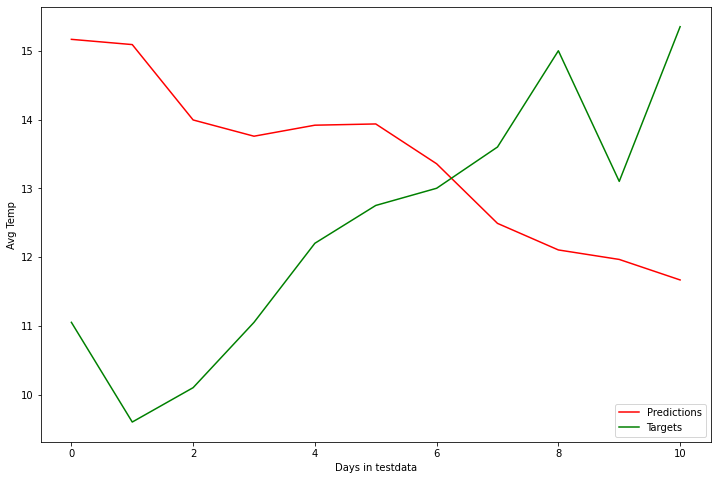

In [49]:
plt.figure(figsize=(12,8))
plt.plot(preds, color='r', label="Predictions")
plt.plot(targets, color='g', label="Targets")
plt.xlabel('Days in testdata')
plt.ylabel('Avg Temp')
plt.legend()

# Predicting

In [50]:
# Now we have to predict 28.10., 03.11 and 24.10.
# Our first data (on 0th index) is from 01.09. and our last data (on 86th index) is from 26.10.
# So we have to predict whole november
# on 87th index is 27.10. 
# on 88th index is 28.10.
# ...
# on 94th index is 03.11.
# on 115th index is 24.11.
# on 121st index is 30.11. and this is the last
# so we need plus 35 value (from 27.10. to 30.11.)

In [51]:
# now we have to create prediction with new data

In [52]:
# we predicting 27.10. temp, and we go further every iterations
# in the first iteration we predict 27.10., saving it, and next time we compute with this data (updating)
# in the second iteration (with data from first iteration) we predict 28.10. and saving it and update data again with this value
# ...
temp = []
temp_copy = X_test.copy()

for i in range(35):
    # predict
    pred_nov = model.predict(temp_copy)
    # deleting the first row
    temp_copy = np.delete(temp_copy, 0, axis=0)
    # store the last prediction, what is in the last row
    temp_new = temp_copy[-1].copy()
    # deleting the first element
    temp_new = np.delete(temp_new, 0)
    # we add a predicted value
    temp_new = np.insert(temp_new,len(temp_new),pred_nov[-1])
    temp.append(pred_nov[-1])
    temp_new = temp_new.reshape(1,20,-1)
    temp_copy = np.concatenate((temp_copy, temp_new))

In [53]:
temp

[array([11.666451], dtype=float32),
 array([12.094148], dtype=float32),
 array([12.124734], dtype=float32),
 array([11.743255], dtype=float32),
 array([11.415187], dtype=float32),
 array([11.103425], dtype=float32),
 array([11.432084], dtype=float32),
 array([11.320577], dtype=float32),
 array([11.176853], dtype=float32),
 array([11.005633], dtype=float32),
 array([10.997781], dtype=float32),
 array([11.058196], dtype=float32),
 array([11.116285], dtype=float32),
 array([11.210084], dtype=float32),
 array([10.969548], dtype=float32),
 array([11.16989], dtype=float32),
 array([10.932438], dtype=float32),
 array([10.701525], dtype=float32),
 array([10.327661], dtype=float32),
 array([10.366082], dtype=float32),
 array([10.300951], dtype=float32),
 array([10.22354], dtype=float32),
 array([10.092293], dtype=float32),
 array([10.011195], dtype=float32),
 array([9.97233], dtype=float32),
 array([9.864327], dtype=float32),
 array([9.783513], dtype=float32),
 array([9.681964], dtype=float32),

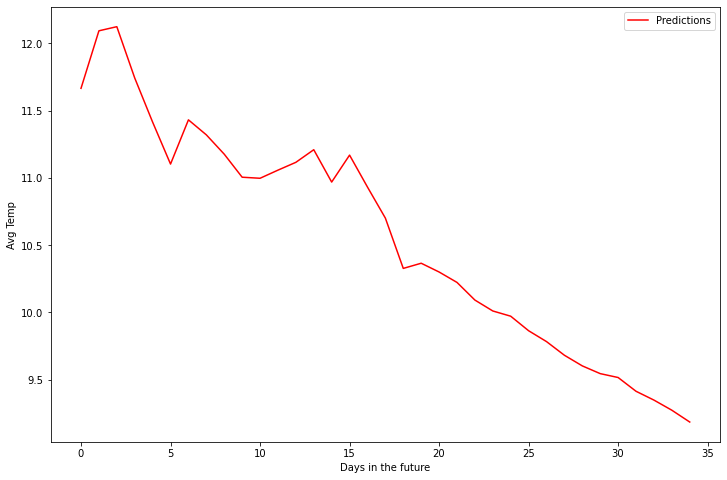

In [56]:
plt.figure(figsize=(12,8))
plt.plot(temp, color='r', label='Predictions')
plt.xlabel('Days in the future')
plt.ylabel('Avg Temp')
plt.legend()

In [57]:
print("The avg. temp on 28.10. is:", temp[1][0])
print("The avg. temp on 03.11. is:", temp[7][0])
print("The avg. temp on 24.11. is:", temp[28][0], "\n")
avg_week1 = (temp[6][0]+temp[7][0]+temp[8][0]+temp[9][0]+temp[10][0]+temp[11][0]+temp[12][0])/7
print('The avg. temp from 02.11 to 09.11. is:', avg_week1, "\n")
avg_month = 0
for i in range(5,35):
    avg_month += temp[i][0]
avg_month= avg_month/30

print('The avg. temp in November is:', avg_month, "\n")


The avg. temp on 28.10. is: 12.094148
The avg. temp on 03.11. is: 11.320577
The avg. temp on 24.11. is: 9.602853 

The avg. temp from 02.11 to 09.11. is: 11.158200945172991 

The avg. temp in November is: 10.356817817687988 

